# Model Train and validation

In [142]:
import glob
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense, Dropout

## Hyperparameter

In [108]:
EPOCHS = 1000
RESULT_SAVE_PATH = '/Users/shim/dl-python-ImageDetection/dataset/results/'
TFRECORD_PATH = '/Users/shim/dl-python-ImageDetection/dataset/tfrecords/'

## Define the model Inception-based

In [121]:
def Model():
    def inception(filters):
        def subnetwork(x):
            # padding=same to enable concatenation with other filters
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    # Add dropout layer
    h = Dropout(0.3)(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    return tf.keras.Model(inputs=x, outputs=y)

## Define the Data Preprocessing Functions 

In [111]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

In [112]:
def get_files_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

## Define the Data Augmentation Function

In [113]:
def augmentation(img, label):
    def flip(x):
        x= tf.image.random_flip_left_right(x)
        x= tf.image.random_flip_up_down(x)
        return x
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0,dtype=tf.float32)>0.5,
                   lambda: tfa.image.rotate(x, tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                                                interpolation='BILINEAR'),
                   lambda: x)
        return x
                    
    def translation(x):
        dx= tf.random.uniform(shape=[], minval=-10.0, maxval=10.0,dtype=tf.float32)
        dy= tf.random.uniform(shape=[], minval=-10.0, maxval=10.0,dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) >0.5,
                   lambda: tfa.image.transform(x, [0,0,dx, 0,0,dy, 0,0], #At the end, 20 is a scale factor
                                              interpolation='BILINEAR'),
                   lambda: x)
        return x
    img = flip(img)
    img = rotate(img)
    img = translation(img)    
            
    return img, label

## Import TFRecords 

In [114]:
tffiles = get_files_list(TFRECORD_PATH)
raw_image_dataset = tf.data.TFRecordDataset(tffiles)

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)

## Splite train, validation set

In [116]:
ds_size = 0
for _ in dataset:
    ds_size += 1

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

train_size = int(ds_size * train_ratio)
validation_size = int(ds_size * validation_ratio)

ds = dataset.shuffle(ds_size, reshuffle_each_iteration=False)

ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).take(validation_size).prefetch(1024).batch(32)
ds_test = ds.skip(train_size + validation_size).prefetch(1024).batch(32)


## Build the Model

In [137]:
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the Model

In [138]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/1000
49/49 [==============================] - 137s 3s/step - loss: 0.0417 - accuracy: 0.9795 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/1000
49/49 [==============================] - 145s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/1000
49/49 [==============================] - 147s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/1000
49/49 [==============================] - 150s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/1000
49/49 [==============================] - 146s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/1000
49/49 [==============================] - 166s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/1000
49/49 [==============================] - 168s 3s/step - loss: 0.0000e+00 - accuracy: 

## Model training Results

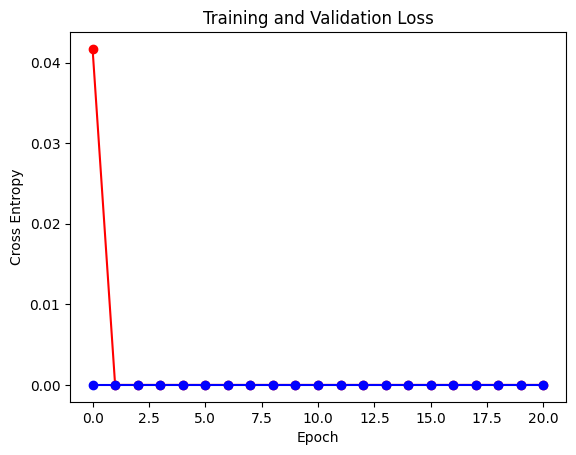

In [143]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

## Model evaluation

In [140]:
test_loss, test_accuracy = model.evaluate(ds_test)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')


17/17 [==============================] - 14s 694ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.0000


## Save the Model

In [144]:
model.save('./model/inception_model.h5')